## Introduction
The following document will include the codes for Q3 - 2,3,4, and Q4-2,3,4.
Kindly note that in addition to this notebook, I utilized the provided code in other py files - svm, utils, dataset, and plot.

In [1]:
from __future__ import print_function, division, absolute_import
#%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import argparse
import time
import sklearn
import scipy.io as sio
from scipy.linalg import sqrtm
import warnings; warnings.simplefilter('ignore')
from plot import plot_images, plot_embedding, plot_embedding_annotation, plot_confusion_matrix
from dataset import read_mnist, read_mnist_twoview
from utils import resize
from svm import linear_svm
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix


## Q3 - PCA Implementation
First, let us proceed with the data processing for the noisy data.

Datapath is: data/noisy_distribute.mat


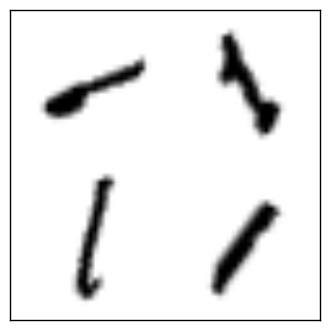

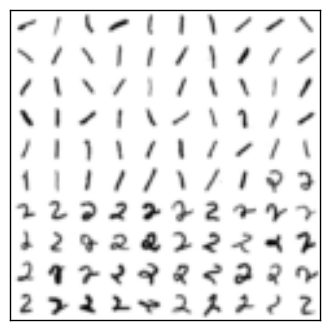

In [2]:
np.random.seed(1)

datapath="data/noisy_distribute.mat"
print("Datapath is: %s" % datapath)

trainData,tuneData,testData = read_mnist(datapath)
#test_x_sample = testData
#test_x_image = np.reshape(test_x_sample, [test_x_sample.shape[0],28,28]).transpose(0, 2, 1)
train_x_sample = trainData.images
train_x_image = np.reshape(train_x_sample, [train_x_sample.shape[0],28,28]).transpose(0, 2, 1)
train_y_sample = np.reshape(trainData.labels, [train_x_sample.shape[0]])
tune_x_sample = tuneData.images
tune_x_image = np.reshape(tune_x_sample, [tune_x_sample.shape[0],28,28]).transpose(0, 2, 1)
tune_y_sample = np.reshape(tuneData.labels, [tune_x_sample.shape[0]])

"""
Visualize a few input digits
"""
ax = plot_images(train_x_image[::1001], 2, 2, 28, 28)
plt.show()

"""
Visualize more input digits, using smaller scale
"""
train_x_rescale = resize(train_x_image,10,10)
ax = plot_images(train_x_rescale[::100], 10, 10, 10, 10)
plt.show()


## Q3.2
First, let us write the PCA class functions.

In [3]:
"""
Q2-2. Implement PCA solution
"""

class PCA(object):
    def __init__(self, n_components):
        """
        Set up PCA
        :in: n_components: number of components to keep
        """
        self.n_components = n_components

    def fit(self, X):
        """
        TODO: fit the model with training data
        :in: X, 2d-array of shape (n_samples, n_features): data matrix
        """
        n_features = X.shape[1]
        self.w1 = np.zeros((self.n_components, n_features))
        self.mu = np.zeros(n_features)
        self.mu = X.mean(axis=0)
        
        #Scale X data matrix
        scaled_X = X - self.mu
        cov_mat = np.cov(scaled_X.T) #Form Covariance Matrix
        
        #Fine eigenvectors
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
        for j in range(self.n_components):
            ranked_eig_val, ranked_eig_vecs = eig_pairs[j]
            self.w1[j,] = ranked_eig_vecs
        self.W = self.w1.T
        return
  
    def transform(self, X):
        """
        TODO: apply PCA on X
        --------
        :in: X, 2d-array of shape (n_samples, n_features): data matrix
        :out:Z, 2d-array of shape (n_samples, n_components): feature matrix
        """
        scaled_X = X - self.mu
        self.Z = scaled_X @ self.W
        return self.Z
    
    def reconstruct(self, Z):
        """
        TODO: transform feature Z back to its original space
        --------
        :in: Z, 2d-array of shape (n_samples, n_components): feature matrix
        :out: X_hat, 2d-array of shape (n_samples, n_features): reconstructed data matrix
        """
        wz = Z @ self.W.T
        self.X_hat = self.mu + wz
        return self.X_hat


In [4]:
"""
Next, we will carry out the PCA on our training set, and use the learned projection and mean matrix to transform our
development set.
"""
#Set reduced dimensions to be 20
n_components = 20

pca = PCA(n_components)

# train
pca.fit(train_x_sample)

# transform
z_pca_train = pca.transform(train_x_sample)
z_pca_tune = pca.transform(tune_x_sample)


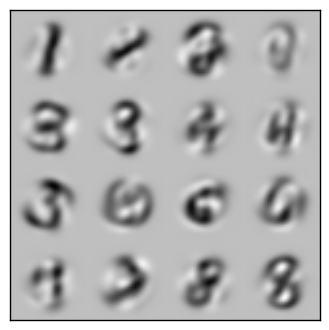

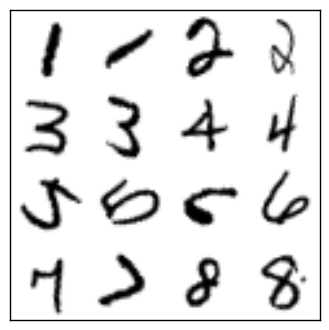

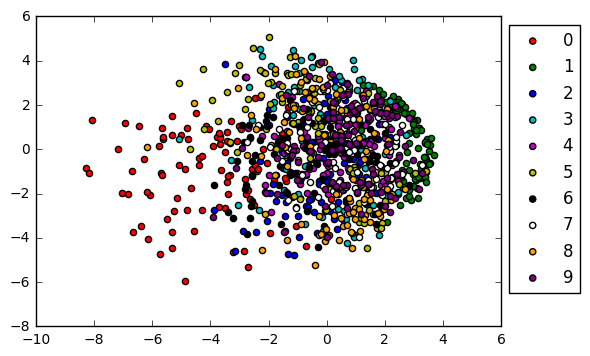

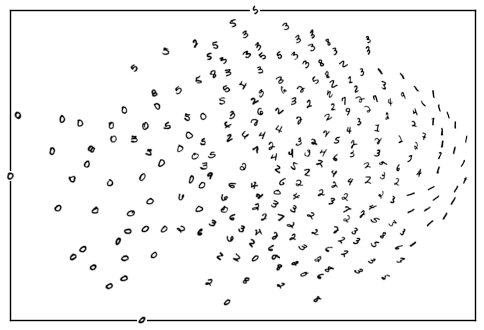

In [5]:
"""
Visualize results
"""
# reconstruct image at k=20
tune_x_image_hat = pca.reconstruct(z_pca_tune).reshape((-1, 28, 28)).transpose((0, 2, 1))
ax = plot_images(tune_x_image_hat[::500], 4, 4, 28, 28)
plt.show()
#Compare with full images
tune_x = tune_x_sample.reshape((-1, 28, 28)).transpose((0, 2, 1))
ax = plot_images(tune_x[::500], 4, 4, 28, 28)
plt.show()

# Visualization without annotation
vis_sample_rate = 10
plot_embedding(z_pca_tune[::vis_sample_rate, :2],tune_y_sample[::vis_sample_rate])
plt.show()

# Visualization with annotation
tune_x_rescale = resize(tune_x_image,10,10)
plot_embedding_annotation(z_pca_tune[::vis_sample_rate, :2],tune_x_rescale[::vis_sample_rate],0.001)
plt.show()


## Q3.3
I will first train the SVM classifier on the raw training set.
Since the "development set" is our test set, I will need to find another validation set.
Hence, I will divide the raw training set into both actual SVM training set, and SVM tuning set, in a 75%:25% ratio.


Performing linear SVM!
c=0.060000, tune error 0.140160
c=0.075000, tune error 0.139920
c=0.090000, tune error 0.140400
tuneerr=0.139920
Normalized confusion matrix


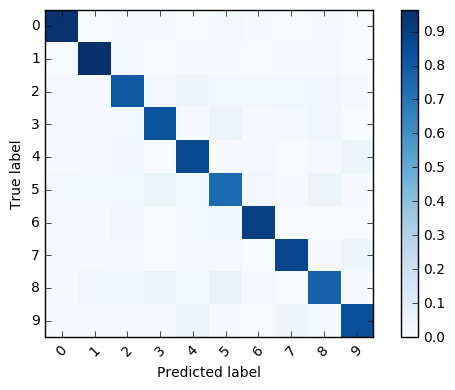

Error Rate:  0.1437


In [6]:
"""
Q2-3. Classify with SVM - Raw Data
"""
#Split training set data into SVM training and SVM tuning set
svm_train1_x,svm_tune1_x,svm_train1_y,svm_tune1_y = train_test_split(train_x_sample,train_y_sample,
                                                                     train_size=.75,random_state=1)

# train on raw image, prediction on development set. Time: Took quite a while :(
#Note numbers in cc are selected after some trials
raw_best_error_tune, raw_pred = linear_svm(svm_train1_x, svm_train1_y, 
                                           svm_tune1_x, svm_tune1_y, tune_x_sample,
                                           cc=[0.06, 0.075, 0.09])

#Set up confusion matrix
cnf_matrix = confusion_matrix(tune_y_sample, raw_pred)

class_names = np.array([0,1,2,3,4,5,6,7,8,9])

#Plot figure
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
#Find accuracy when SVM applied onto development set
print ("Error Rate: ", error_rate)


Performing linear SVM!
c=0.075000, tune error 0.197280
c=0.100000, tune error 0.196880
c=0.125000, tune error 0.197040
tuneerr=0.196880
Normalized confusion matrix


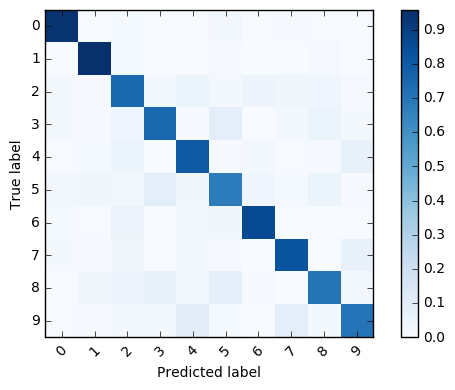

Error Rate:  0.2023


In [7]:
"""
Q2-3. Classify with SVM - PCA Data (k=20)
"""

# train on PCA features
#First, split transformed data into training and tuning set
Z_train1_x, Z_tune1_x,Z_train1_y,Z_tune1_y = train_test_split(z_pca_train,train_y_sample,
                                                                     train_size=.75,random_state=1)

#Perform SVM, with development set as set being predicted
pca_best_error_tune, pca_pred = linear_svm(Z_train1_x, Z_train1_y, 
                                           Z_tune1_x, Z_tune1_y, z_pca_tune,
                                            cc=[0.075, 0.1, 0.125])

#Find and plot confusion matrix
class_names = np.array([0,1,2,3,4,5,6,7,8,9])
cnf_matrix = confusion_matrix(tune_y_sample, pca_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

#Find accuracy when SVM applied onto development set
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
print ("Error Rate: ", error_rate)


Next, let us repeat the above cell, but with different values of k. Let us try k=5, and k=100.

In [8]:
#k = 5
n_components = 5
pca = PCA(n_components)
# train
pca.fit(train_x_sample)
# transform
z_pca_train = pca.transform(train_x_sample)
z_pca_tune = pca.transform(tune_x_sample)

#First, split transformed data into training and tuning set
Z_train1_x, Z_tune1_x,Z_train1_y,Z_tune1_y = train_test_split(z_pca_train,train_y_sample,
                                                                     train_size=.75,random_state=1)

#Perform SVM, with development set as set being predicted
pca_best_error_tune, pca_pred = linear_svm(Z_train1_x, Z_train1_y, 
                                           Z_tune1_x, Z_tune1_y, z_pca_tune,
                                            cc=[0.075, 0.1, 0.125])

#Find accuracy when SVM applied onto development set
cnf_matrix = confusion_matrix(tune_y_sample, pca_pred)
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
print ("Error Rate: ", error_rate)


Performing linear SVM!
c=0.075000, tune error 0.447520
c=0.100000, tune error 0.446960
c=0.125000, tune error 0.447280
tuneerr=0.446960
Error Rate:  0.454


In [9]:
#k = 100
n_components = 100
pca = PCA(n_components)
pca.fit(train_x_sample)
z_pca_train = pca.transform(train_x_sample)
z_pca_tune = pca.transform(tune_x_sample)
Z_train1_x, Z_tune1_x,Z_train1_y,Z_tune1_y = train_test_split(z_pca_train,train_y_sample,
                                                                     train_size=.75,random_state=1)
pca_best_error_tune, pca_pred = linear_svm(Z_train1_x, Z_train1_y, 
                                           Z_tune1_x, Z_tune1_y, z_pca_tune,
                                            cc=[0.075, 0.1, 0.125])
cnf_matrix = confusion_matrix(tune_y_sample, pca_pred)
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
print ("Error Rate: ", error_rate)


Performing linear SVM!
c=0.075000, tune error 0.142880
c=0.100000, tune error 0.142320
c=0.125000, tune error 0.142960
tuneerr=0.142320
Error Rate:  0.1448


## Q3.4
Next, we will proceed with a small set of labelled training data for our SVM classifier. We will first proceed with the data processing. Since 2 arrays are provided, and 50 is a small number to split up, we will train our SVM on 1 set of 50 observations, and use the other set of 50 observations as a validation/hyperparameter tuning set.

In addition, we also set up a parallel experiment, where we train a PCA on the remaining unlabelled data in the original training set (i.e. 50 000 - 100 observations left), and set k=20. Then, we will perform the SVM on the transformed 50 observations as SVM training set. 

The SVM will be evaluated on the development set (10 000 observations), which is either reduced to 20 dimensions (in latter) or not reduced (in former).

In [10]:
"""
Q2-4. Train with IDX
Data processing
"""

#Transform the information in IDX into an array of indices
#Note that we will use the same variables for CCA later
idx = sio.loadmat("data\idx.mat")
subset_1 = idx["p1"]
subset_2 = idx["p2"]
subset_both = np.concatenate((subset_1,subset_2),axis=1)
subset_1 = np.reshape(subset_1, (50,))
subset_2 = np.reshape(subset_2, (50,))
l = [i for i in range(50000)]

#Find set of indices not in labelled data 1 and 2
subset_both_comp = np.array([x for x in l if x not in subset_both])

#Create new training sets of 50 variables each, and their labels
train_x_subset1 = train_x_sample[subset_1,]
train_x_subset2 = train_x_sample[subset_2,]
train_y_subset1 = train_y_sample[subset_1,]
train_y_subset2 = train_y_sample[subset_2,]

#Next, use remaining 49,900 data for PCA learning
train_x_idx = train_x_sample[subset_both_comp,]


Performing linear SVM!
c=0.050000, tune error 0.760000
c=0.100000, tune error 0.720000
c=0.500000, tune error 0.720000
tuneerr=0.720000
Normalized confusion matrix


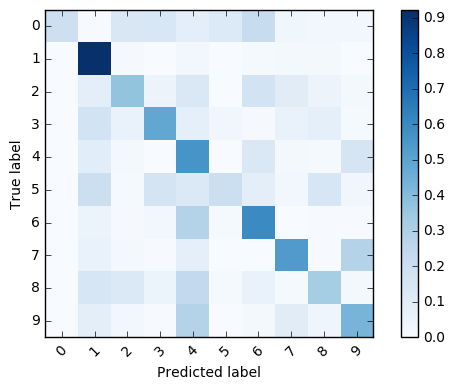

Error Rate:  0.5366


In [11]:
"""
SVM Classifier Learning
We use Subset 1 of 50 datapoints for training, and subset 2 for validation/tuning
Perform first ON Non-PCA Data
"""
#FIRST PERFORM on non-PCA data
raw_50_best_error_tune, raw_50_pred = linear_svm(train_x_subset1, train_y_subset1, 
                                           train_x_subset2, train_y_subset2, tune_x_sample,
                                           cc=[0.05, 0.1, 0.5])

cnf_matrix_50 = confusion_matrix(tune_y_sample, raw_50_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_50, classes=class_names, normalize=True)
plt.show()
error_rate = 1 - (np.matrix.trace(cnf_matrix_50))/tune_y_sample.shape[0]
#Find accuracy when SVM applied onto development set
print ("Error Rate: ", error_rate)


Performing linear SVM!
c=0.050000, tune error 0.540000
c=0.100000, tune error 0.520000
c=0.500000, tune error 0.520000
tuneerr=0.520000
Normalized confusion matrix


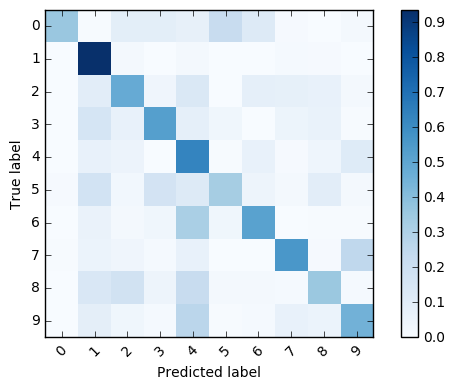

Error Rate:  0.4849


In [12]:
"""
Perform next ON PCA-transformed Data
"""
n_components=20
pca = PCA(n_components)
# train
pca.fit(train_x_idx)

# transform development set into PCA projection
z_idx_pca_tune = pca.transform(tune_x_sample)
z_idx_pca_subset1 = pca.transform(train_x_subset1)
z_idx_pca_subset2 = pca.transform(train_x_subset2)

pca_50_best_error_tune, pca_50_pred = linear_svm(z_idx_pca_subset1, train_y_subset1, 
                                           z_idx_pca_subset2, train_y_subset2, z_idx_pca_tune,
                                           cc=[0.05, 0.1, 0.5])

cnf_matrix_50 = confusion_matrix(tune_y_sample, pca_50_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_50, classes=class_names, normalize=True)
plt.show()
error_rate = 1 - (np.matrix.trace(cnf_matrix_50))/tune_y_sample.shape[0]
#Find accuracy when SVM applied onto development set
print ("Error Rate: ", error_rate)


Now, repeat the above 3 blocks of code, just with the original MIST data.

Datapath is: data/original_distribute.mat


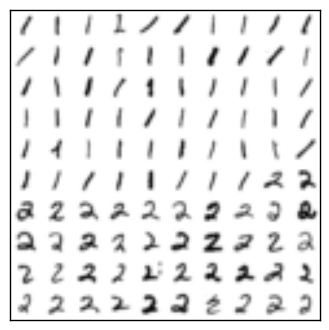

In [13]:
"""
SVM Classifier Learning
APPLY ON ORIGINAL DATASET
"""
datapath="data/original_distribute.mat"
print("Datapath is: %s" % datapath)

c_trainData,c_tuneData,c_testData = read_mnist(datapath)
c_train_x_sample = c_trainData.images
c_train_x_image = np.reshape(c_train_x_sample, [c_train_x_sample.shape[0],28,28]).transpose(0, 2, 1)
c_train_y_sample = np.reshape(c_trainData.labels, [c_train_x_sample.shape[0]])
c_tune_x_sample = c_tuneData.images
c_tune_x_image = np.reshape(c_tune_x_sample, [c_tune_x_sample.shape[0],28,28]).transpose(0, 2, 1)
c_tune_y_sample = np.reshape(c_tuneData.labels, [c_tune_x_sample.shape[0]])

"""
Visualize more input digits, using smaller scale
"""
c_train_x_rescale = resize(c_train_x_image,10,10)
ax = plot_images(c_train_x_rescale[::100], 10, 10, 10, 10)
plt.show()

c_train_x_subset1 = c_train_x_sample[subset_1,]
c_train_x_subset2 = c_train_x_sample[subset_2,]
c_train_y_subset1 = c_train_y_sample[subset_1,]
c_train_y_subset2 = c_train_y_sample[subset_2,]
c_train_x_idx = c_train_x_sample[subset_both_comp,]


#First, use remaining data for learning
c_train_x_idx = c_train_x_sample[subset_both_comp,]
n_components = 20
c_pca = PCA(n_components)
# train
c_pca.fit(c_train_x_idx)

# transform development set into PCA projection
c_z_idx_pca_tune = c_pca.transform(c_tune_x_sample)
c_z_idx_pca_subset1 = c_pca.transform(c_train_x_subset1)
c_z_idx_pca_subset2 = c_pca.transform(c_train_x_subset2)


Performing linear SVM!
c=0.050000, tune error 0.300000
c=0.100000, tune error 0.320000
c=0.500000, tune error 0.320000
tuneerr=0.300000
Normalized confusion matrix


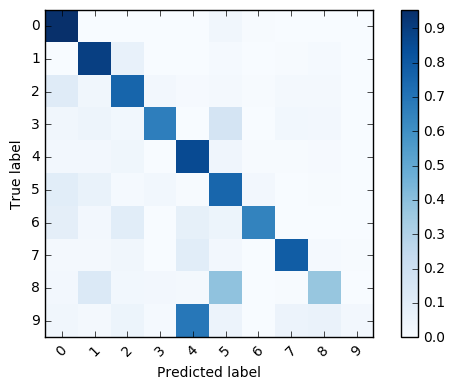

Error Rate:  0.3283


In [14]:
"""
CLEAN SVM Classifier Learning
FIRST PERFORM on non-PCA data
"""
c_raw_50_best_error_tune, c_raw_50_pred = linear_svm(c_train_x_subset2, c_train_y_subset2, 
                                           c_train_x_subset1, c_train_y_subset1, c_tune_x_sample,
                                           cc=[0.05, 0.1, 0.5])

c_cnf_matrix_50 = confusion_matrix(c_tune_y_sample, c_raw_50_pred)
plt.figure()
plot_confusion_matrix(c_cnf_matrix_50, classes=class_names, normalize=True)
plt.show()
error_rate = 1 - (np.matrix.trace(c_cnf_matrix_50))/c_tune_y_sample.shape[0]
#Find accuracy when SVM applied onto development set
print ("Error Rate: ", error_rate)


Performing linear SVM!
c=0.100000, tune error 0.360000
c=0.200000, tune error 0.340000
c=0.500000, tune error 0.340000
c=1.000000, tune error 0.340000
tuneerr=0.340000
Normalized confusion matrix


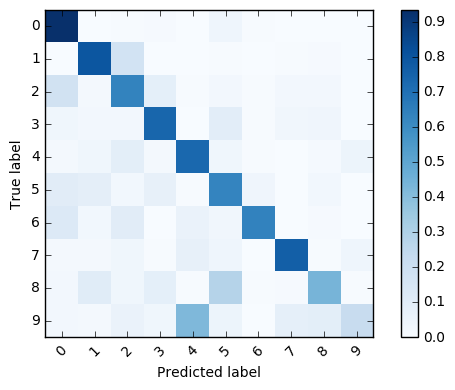

Error Rate:  0.3477


In [15]:
"""
CLEAN SVM Classifier Learning
PERFORM on non-PCA data
"""
#PERFORM on PCA_transformed data
c_pca_50_best_error_tune, c_pca_50_pred = linear_svm(c_z_idx_pca_subset2, c_train_y_subset2, 
                                           c_z_idx_pca_subset1, c_train_y_subset1, c_z_idx_pca_tune,
                                           cc=[0.1, 0.2, 0.5, 1])

c_cnf_matrix_50 = confusion_matrix(c_tune_y_sample, c_pca_50_pred)
plt.figure()
plot_confusion_matrix(c_cnf_matrix_50, classes=class_names, normalize=True)
plt.show()
error_rate = 1 - (np.matrix.trace(c_cnf_matrix_50))/c_tune_y_sample.shape[0]
#Find accuracy when SVM applied onto development set
print ("Error Rate: ", error_rate)


## Q4 - CCA Implementation
First, let us start with the data processing portion of the question.

Data path is: data/noisy_two_view_distribute.mat


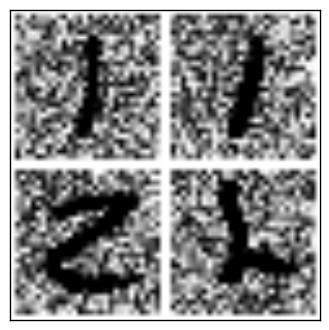

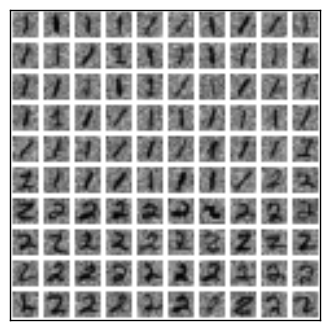

In [16]:
np.random.seed(1)

datapath="data/noisy_two_view_distribute.mat"
print("Data path is: %s" % datapath)

trainData,tuneData,testData1,testData2=read_mnist_twoview(datapath)
train_x_sample1 = trainData.images
train_x_sample2 = trainData.images2
train_x_image1 = np.reshape(train_x_sample1, [train_x_sample1.shape[0],28,28]).transpose(0, 2, 1)
train_x_image2 = np.reshape(train_x_sample2, [train_x_sample2.shape[0],28,28]).transpose(0, 2, 1)
train_y_sample = np.reshape(trainData.labels, [train_x_sample1.shape[0]])
tune_x_sample1 = tuneData.images
tune_x_sample2 = tuneData.images2
tune_x_image1 = np.reshape(tune_x_sample1, [tune_x_sample1.shape[0],28,28]).transpose(0, 2, 1)
tune_x_image2 = np.reshape(tune_x_sample2, [tune_x_sample2.shape[0],28,28]).transpose(0, 2, 1)
tune_y_sample = np.reshape(tuneData.labels, [tune_x_sample1.shape[0]])

"""
Visualize a few input digits for View 2 (Uniform pixels added)
"""
ax = plot_images(train_x_image2[::3000], 2, 2, 28, 28)
plt.show()

"""
Visualize more input digits, using smaller scale
"""
train_x_rescale = resize(train_x_image2,10,10)
ax = plot_images(train_x_rescale[::100], 10, 10, 10, 10)
plt.show()


## Q4.2
Below are the class and functions for CCA.

In [17]:
"""
3. Reduce dimension with CCA
"""
class CCA(object):
    def __init__(self, n_components, r1, r2):
        """
        Set up CCA
        ------
        :in:        
        n_components: number of components to keep
        r1, r2: regularization coefficient on view 1 and view 2
        """
        self.n_components, self.r1, self.r2 = n_components, r1, r2

    def fit(self, X, Y):
        """
        TODO: fit the model with training data
        --------
        :in: 
        X, 2d-array of shape (n_samples, view1_features): data matrix of view 1
        Y, 2d-array of shape (n_samples, view2_features): data matrix of view 2
        """
        n = X.shape[0]
        nx_features, ny_features = X.shape[1], Y.shape[1]
        total_features = nx_features+ny_features
        self.mX, self.mY = np.zeros(nx_features), np.zeros(ny_features)
        self.mX = X.mean(axis=0)
        self.mY = Y.mean(axis=0)
        scaled_X = X - self.mX
        scaled_Y = Y - self.mY
        
        self.Wx, self.Wy = np.zeros((nx_features, self.n_components)), np.zeros((ny_features, self.n_components))

        #Set up the variables required for EVD
        XY = np.concatenate((scaled_X, scaled_Y), axis=1)        
        cov_X = np.cov(scaled_X.T)
        cov_Y = np.cov(scaled_Y.T)
        x_rI = self.r1 * np.identity(nx_features)
        y_rI = self.r2 * np.identity(ny_features)
        
        inverse_cov_X = np.linalg.inv(cov_X + x_rI)
        inverse_cov_Y = np.linalg.inv(cov_Y + y_rI)
        cov_full = np.cov(XY.T)
        cov_XY = cov_full[0:nx_features, nx_features:total_features]
        cov_YX = cov_XY.T
        
        #Wx        
        final_mat_x= inverse_cov_X @ cov_XY @ inverse_cov_Y @ cov_YX
        eig_vals_x, eig_vecs_x = np.linalg.eig(final_mat_x)
        eig_pairs_x = [(np.abs(eig_vals_x[i]), eig_vecs_x[:,i]) for i in range(len(eig_vals_x))]
        
        for j in range(self.n_components):
            ranked_eig_val_x, ranked_eig_vecs_x = eig_pairs_x[j]
            self.Wx[:,j] = ranked_eig_vecs_x

        #Wxy       
        final_mat_y = inverse_cov_Y @ cov_YX @ inverse_cov_X @ cov_XY
        eig_vals_y, eig_vecs_y = np.linalg.eig(final_mat_y)
        eig_pairs_y = [(np.abs(eig_vals_y[i]), eig_vecs_y[:,i]) for i in range(len(eig_vals_y))]
        
        for k in range(self.n_components):
            ranked_eig_val_y, ranked_eig_vecs_y = eig_pairs_y[k]
            self.Wy[:,k] = ranked_eig_vecs_y
        
        return

    def transform(self, X, view=1):
        """
        TODO: apply CCA on data X of a given view
        --------
        :in: X, 2d-array of shape (n_samples, n_features): data matrix
        view: view index (1 or 2)
        :out: Z, 2d-array of shape (n_samples, n_components): feature matrix
        """
        if view == 1:
            scaled_X = X - self.mX
            self.Z = scaled_X @ self.Wx
        else:
            scaled_Y = X - self.mY
            self.Z = scaled_Y @ self.Wy
        return self.Z
        
        
    def reconstruct(self, Z, view=1):
        """
        TODO: transform feature Z back to its original space
        --------
        :in: Z, 2d-array of shape (n_samples, n_components): feature matrix
        :out: X_hat, 2d-array of shape (n_samples, n_features): reconstructed data matrix
        """
        if view == 1:
            wz = Z @ self.Wx.T
            self.hat = self.mX + wz
        else:
            wz = Z @ self.Wy.T
            self.hat = self.mY + wz
        return self.hat


## Q4.3
Next, we willl transform the training data, before visualizing the first 2 projected dimensions. 

Then, we train a linear SVM clssifier using the View 1 RAW training set, before moving on to using the training set that has been CCA-transformed.

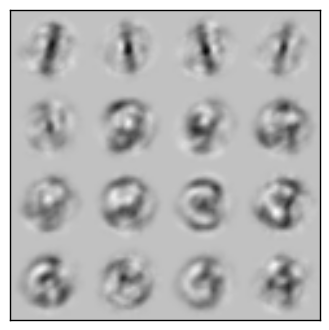

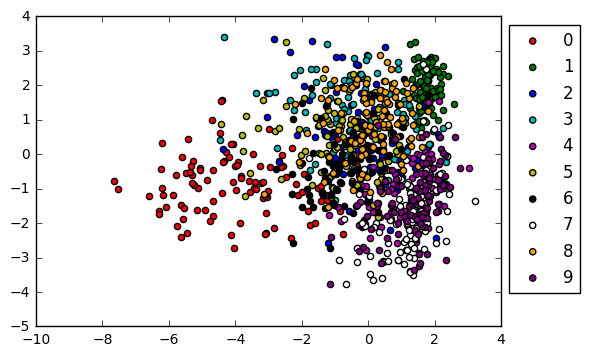

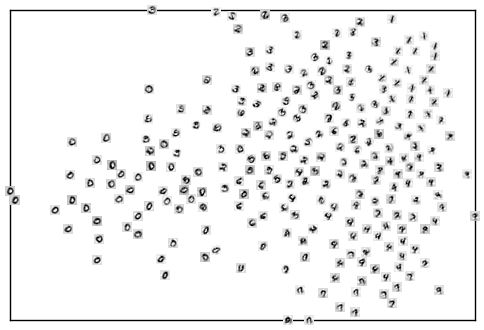

In [18]:
n_components, r1, r2 = 20, 1, 1
cca = CCA(n_components, r1, r2)

# train
cca.fit(train_x_sample1, train_x_sample2)

# transform
z_cca_train = cca.transform(train_x_sample1)
z_cca_tune = cca.transform(tune_x_sample1)

# reconstruct
tune_x_image_hat = cca.reconstruct(z_cca_tune).reshape((-1, 28, 28)).transpose((0, 2, 1))
ax = plot_images(tune_x_image_hat[::200], 4, 4, 28, 28)
plt.show()

# Visualization without annotation
vis_sample_rate = 10
plot_embedding(z_cca_tune[::vis_sample_rate, :2], tune_y_sample[::vis_sample_rate])
plt.show()

# Visualization with annotation
tune_x_rescale = resize(tune_x_image_hat,10,10)
plot_embedding_annotation(z_cca_tune[::vis_sample_rate, :2],tune_x_rescale[::vis_sample_rate],0.001)
plt.show()


Next, we will perform SVM on the view 1 data, first on the raw data, then on the CCA (k=20, r=1) transformed data.
We will split our original training set into SVM training and tuning set, before applying the classifier to the development set.

Performing linear SVM!
c=0.050000, tune error 0.140880
c=0.100000, tune error 0.140800
c=0.150000, tune error 0.142960
tuneerr=0.140800
Normalized confusion matrix


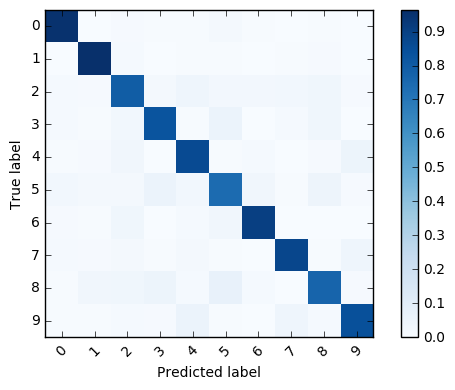

Error Rate:  0.1444


In [19]:
"""
4-3. Classify with SVM
"""
"""
Train on raw view1 data 
"""
train1_x, tune1_x,train1_y,tune1_y = train_test_split(train_x_sample1,train_y_sample,
                                                                     train_size=.75,random_state=1)

best_error_tune,raw_pred = linear_svm(train1_x, train1_y, 
                                           tune1_x, tune1_y, tune_x_sample1,
                                            cc=[0.05, 0.1, 0.15])

cnf_matrix = confusion_matrix(tune_y_sample, raw_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()
#Find accuracy when SVM applied onto development set
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
print ("Error Rate: ", error_rate)


Performing linear SVM!
c=0.050000, tune error 0.176480
c=0.100000, tune error 0.175200
c=0.150000, tune error 0.175360
tuneerr=0.175200
Normalized confusion matrix


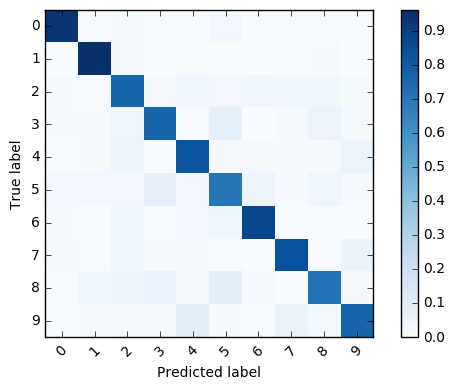

Error Rate:  0.1843


In [20]:
"""
4-3. Classify with SVM
Train on CCA-transformed data
"""

# train on CCA features
Z_train_cca_x, Z_tune1_cca_x,Z_train1_cca_y,Z_tune1_cca_y = train_test_split(z_cca_train,train_y_sample,
                                                                     train_size=.75,random_state=1)

cca_best_error_tune,cca_pred = linear_svm(Z_train_cca_x, Z_train1_cca_y, 
                                           Z_tune1_cca_x, Z_tune1_cca_y, z_cca_tune,
                                            cc=[0.05, 0.1, 0.15])

class_names = np.array([0,1,2,3,4,5,6,7,8,9])
cnf_matrix = confusion_matrix(tune_y_sample, cca_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()
#Find accuracy when SVM applied onto development set
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
print ("Error Rate: ", error_rate)


Next, we will vary the values of k and r, and obbserve the impact on the results.

In [21]:
"""
4-3. Repeat above for different values of dimensions and regularization coefficients
First fix regularization = 1,1, and consider no. of dimensions = 5,200
Next, fix dimension=50, and consider r = 0.1, 10
"""
"""
dimension = 5
"""
n_components, r1, r2 = 5, 1, 1
cca_a = CCA(n_components, r1, r2)
# train
cca_a.fit(train_x_sample1, train_x_sample2)
# transform
z_cca_train = cca_a.transform(train_x_sample1)
z_cca_tune = cca_a.transform(tune_x_sample1)
# train on CCA features
Z_train_cca_x, Z_tune1_cca_x,Z_train1_cca_y,Z_tune1_cca_y = train_test_split(z_cca_train,train_y_sample,
                                                                     train_size=.75,random_state=1)
cca_best_error_tune,cca_pred = linear_svm(Z_train_cca_x, Z_train1_cca_y, 
                                           Z_tune1_cca_x, Z_tune1_cca_y, z_cca_tune,
                                            cc=[0.1, 0.5, 1])

cnf_matrix = confusion_matrix(tune_y_sample, cca_pred)
#Find accuracy when SVM applied onto development set
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
print ("Error Rate: ", error_rate)


Performing linear SVM!
c=0.100000, tune error 0.256960
c=0.500000, tune error 0.256400
c=1.000000, tune error 0.256640
tuneerr=0.256400
Error Rate:  0.2602


In [22]:
"""
dimension = 200
"""
n_components, r1, r2 = 200, 1, 1
cca_a = CCA(n_components, r1, r2)
# train
cca_a.fit(train_x_sample1, train_x_sample2)
# transform
z_cca_train = cca_a.transform(train_x_sample1)
z_cca_tune = cca_a.transform(tune_x_sample1)
# train on CCA features
Z_train_cca_x, Z_tune1_cca_x,Z_train1_cca_y,Z_tune1_cca_y = train_test_split(z_cca_train,train_y_sample,
                                                                     train_size=.75,random_state=1)
cca_best_error_tune,cca_pred = linear_svm(Z_train_cca_x, Z_train1_cca_y, 
                                           Z_tune1_cca_x, Z_tune1_cca_y, z_cca_tune,
                                            cc=[0.01, 0.05, 0.1])
cnf_matrix = confusion_matrix(tune_y_sample, cca_pred)
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
print ("Error Rate: ", error_rate)


Performing linear SVM!
c=0.010000, tune error 0.142640
c=0.050000, tune error 0.138240
c=0.100000, tune error 0.138960
tuneerr=0.138240
Error Rate:  0.1442


In [23]:
"""
dimension = 50, r = 1
"""
n_components, r1, r2 = 50, 1, 1
cca_a = CCA(n_components, r1, r2)
# train
cca_a.fit(train_x_sample1, train_x_sample2)
# transform
z_cca_train = cca_a.transform(train_x_sample1)
z_cca_tune = cca_a.transform(tune_x_sample1)
# train on CCA features
Z_train_cca_x, Z_tune1_cca_x,Z_train1_cca_y,Z_tune1_cca_y = train_test_split(z_cca_train,train_y_sample,
                                                                     train_size=.75,random_state=1)
cca_best_error_tune,cca_pred = linear_svm(Z_train_cca_x, Z_train1_cca_y, 
                                           Z_tune1_cca_x, Z_tune1_cca_y, z_cca_tune,
                                            cc=[0.01, 0.05, 0.1])
cnf_matrix = confusion_matrix(tune_y_sample, cca_pred)
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
print ("Error Rate: ", error_rate)


Performing linear SVM!
c=0.010000, tune error 0.153200
c=0.050000, tune error 0.150560
c=0.100000, tune error 0.149840
tuneerr=0.149840
Error Rate:  0.1553


In [24]:
"""
dimension = 50, r=0.1, 0.1
"""
n_components, r1, r2 = 50, 0.1, 0.1
cca_a = CCA(n_components, r1, r2)
# train
cca_a.fit(train_x_sample1, train_x_sample2)
# transform
z_cca_train = cca_a.transform(train_x_sample1)
z_cca_tune = cca_a.transform(tune_x_sample1)
# train on CCA features
Z_train_cca_x, Z_tune1_cca_x,Z_train1_cca_y,Z_tune1_cca_y = train_test_split(z_cca_train,train_y_sample,
                                                                     train_size=.75,random_state=1)
cca_best_error_tune,cca_pred = linear_svm(Z_train_cca_x, Z_train1_cca_y, 
                                           Z_tune1_cca_x, Z_tune1_cca_y, z_cca_tune,
                                            cc=[0.01, 0.1, 0.5, 1])
cnf_matrix = confusion_matrix(tune_y_sample, cca_pred)
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
print (error_rate)


Performing linear SVM!
c=0.010000, tune error 0.159200
c=0.100000, tune error 0.151280
c=0.500000, tune error 0.150880
c=1.000000, tune error 0.150960
tuneerr=0.150880
0.1578


In [25]:
"""
dimension = 50, r=10, 10
"""
n_components, r1, r2 = 50, 10, 10
cca_a = CCA(n_components, r1, r2)
# train
cca_a.fit(train_x_sample1, train_x_sample2)
# transform
z_cca_train = cca_a.transform(train_x_sample1)
z_cca_tune = cca_a.transform(tune_x_sample1)
# train on CCA features
Z_train_cca_x, Z_tune1_cca_x,Z_train1_cca_y,Z_tune1_cca_y = train_test_split(z_cca_train,train_y_sample,
                                                                     train_size=.75,random_state=1)
cca_best_error_tune,cca_pred = linear_svm(Z_train_cca_x, Z_train1_cca_y, 
                                           Z_tune1_cca_x, Z_tune1_cca_y, z_cca_tune,
                                            cc=[0.01, 0.1, 0.5, 1])
cnf_matrix = confusion_matrix(tune_y_sample, cca_pred)
error_rate = 1 - (np.matrix.trace(cnf_matrix))/tune_y_sample.shape[0]
print ("Error Rate: ", error_rate)


Performing linear SVM!
c=0.010000, tune error 0.153680
c=0.100000, tune error 0.150720
c=0.500000, tune error 0.150880
c=1.000000, tune error 0.150880
tuneerr=0.150720
Error Rate:  0.155


## Q4.4
Next, we will repeat Q3.4, except with CCA being applied now.

In [26]:
"""
Q4-4. Train with IDX
Data processing
"""

train_x_view1_subset1 = train_x_sample1[subset_1,]
train_x_view2_subset1 = train_x_sample2[subset_1,]
train_x_view1_subset2 = train_x_sample1[subset_2,]
train_x_view2_subset2 = train_x_sample2[subset_2,]
train_y_subset1 = train_y_sample[subset_1,]
train_y_subset2 = train_y_sample[subset_2,]
train_x_view1_idx = train_x_sample1[subset_both_comp,]
train_x_view2_idx = train_x_sample2[subset_both_comp,]

#First, use remaining data for learning
cca_idx = CCA(20,1,1)
# train
cca_idx.fit(train_x_view1_idx, train_x_view2_idx)

# transform development set into PCA projection
z_idx_cca_tune = cca_idx.transform(tune_x_sample1)
z_idx_cca_subset1 = cca_idx.transform(train_x_view1_subset1)
z_idx_cca_subset2 = cca_idx.transform(train_x_view1_subset2)


Performing linear SVM!
c=0.200000, tune error 0.460000
c=0.600000, tune error 0.460000
c=1.000000, tune error 0.460000
tuneerr=0.460000
Normalized confusion matrix


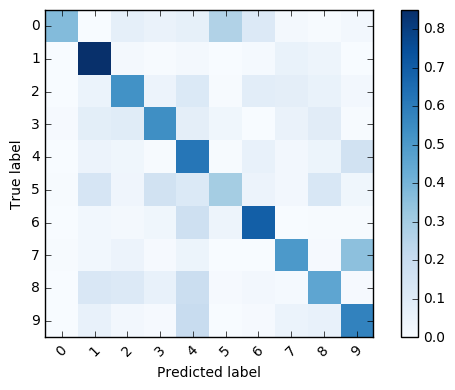

Error Rate:  0.4553


In [27]:
"""
SVM classifer learning
We use subset 1 for training, and subset 2 for validation/tuning
"""
#PERFORMANCE on non-PCA data - 
#REFER TO PREVIOUS QUESTION. Error rate = 0.3283


#PERFORM on CCA_transformed data
cca_50_best_error_tune, cca_50_pred = linear_svm(z_idx_cca_subset1, train_y_subset1, 
                                           z_idx_cca_subset2, train_y_subset2, z_idx_cca_tune,
                                           cc=[0.2, 0.6, 1])

cnf_matrix_50 = confusion_matrix(tune_y_sample, cca_50_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_50, classes=class_names, normalize=True)
plt.show()
error_rate = 1 - (np.matrix.trace(cnf_matrix_50))/tune_y_sample.shape[0]
#Find accuracy when SVM applied onto development set
print ("Error Rate: ", error_rate)


Hence, the SVM classifier performs worse under CCA than with the raw data or PCA transformed data.